# Darcy Flow Example - Neural Operator Pytorch

In [1]:
#!pip install -U neuraloperator

### Imports and global settings

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D
from neuralop.models import UNO, FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

plt.rcParams.update({"figure.figsize": (7, 7), "axes.titlesize": 12})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0



### Hyper‑parameters and constants


In [3]:
N_TRAIN = 1000
BATCH_SIZE = 32
TEST_RESOLUTIONS = [16, 32]
N_TESTS = [100, 50]
TEST_BATCH_SIZES = [32, 32]
EPOCHS = 20
LR = 8e-3
WEIGHT_DECAY = 1e-4
T_MAX = 30  # cosine scheduler

### Utility functions

In [4]:
def load_data():
    train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=N_TRAIN,
        batch_size=BATCH_SIZE,
        test_resolutions=TEST_RESOLUTIONS,
        n_tests=N_TESTS,
        test_batch_sizes=TEST_BATCH_SIZES,
    )
    
    data_processor = data_processor.to(device)
    return train_loader, test_loaders, data_processor


def build_optimizer(model):
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)
    return optimizer, scheduler


def get_losses():
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    return h1loss, {"h1": h1loss, "l2": l2loss}


def train_model(model, train_loader, test_loaders, data_processor, name="model"):
    model = model.to(device)
    optimizer, scheduler = build_optimizer(model)
    train_loss, eval_losses = get_losses()

    print(f"\n{name} has {count_model_params(model)} parameters\n")

    trainer = Trainer(
        model=model,
        n_epochs=EPOCHS,
        device=device,
        data_processor=data_processor,
        wandb_log=False,
        eval_interval=3,
        use_distributed=False,
        verbose=True,
    )

    trainer.train(
        train_loader=train_loader,
        test_loaders=test_loaders,
        optimizer=optimizer,
        scheduler=scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    return model  


def visualize_single_sample(train_loader, data_processor):
    sample = data_processor.preprocess(train_loader.dataset[0], batched=False)
    k = sample["x"]
    u = sample["y"]

    pos_embed = GridEmbedding2D(in_channels=1)
    k_aug = pos_embed(k.unsqueeze(0)).squeeze(0)

    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes[0, 0].imshow(k_aug[0].cpu().numpy(), cmap="gray");   axes[0, 0].set_title("k (input)")
    axes[0, 1].imshow(u.squeeze().cpu().numpy());             axes[0, 1].set_title("u (label)")
    axes[1, 0].imshow(k_aug[1].cpu().numpy());               axes[1, 0].set_title("y‑coord")
    axes[1, 1].imshow(k_aug[2].cpu().numpy());               axes[1, 1].set_title("x‑coord")
    fig.suptitle("One input sample + positional embeddings")
    plt.tight_layout(); plt.show()


def plot_prediction_grid(model, data_processor, test_loader, res_label, n_samples=3):
    """Plot k, true u, predicted u for first *n_samples* from *test_loader*."""
    fig = plt.figure(figsize=(7, 7))
    model.eval()
    with torch.no_grad():
        for idx in range(n_samples):
            data = data_processor.preprocess(test_loader.dataset[idx], batched=False)
            k = data["x"]
            u_true = data["y"]
            u_pred = model(k.unsqueeze(0).to(device)).squeeze().cpu()

            ax = fig.add_subplot(n_samples, 3, idx * 3 + 1)
            ax.imshow(k[0].cpu().numpy(), cmap="gray")
            ax.set_title("Input k" if idx == 0 else "")
            ax.axis("off")

            ax = fig.add_subplot(n_samples, 3, idx * 3 + 2)
            ax.imshow(u_true.squeeze().cpu().numpy())
            ax.set_title("GT u" if idx == 0 else "")
            ax.axis("off")

            ax = fig.add_subplot(n_samples, 3, idx * 3 + 3)
            ax.imshow(u_pred.detach().cpu().numpy())
            ax.set_title("Pred u" if idx == 0 else "")
            ax.axis("off")

    fig.suptitle(f"Predictions at {res_label}")
    plt.tight_layout()
    plt.show()

### Load data and visualize a sample

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


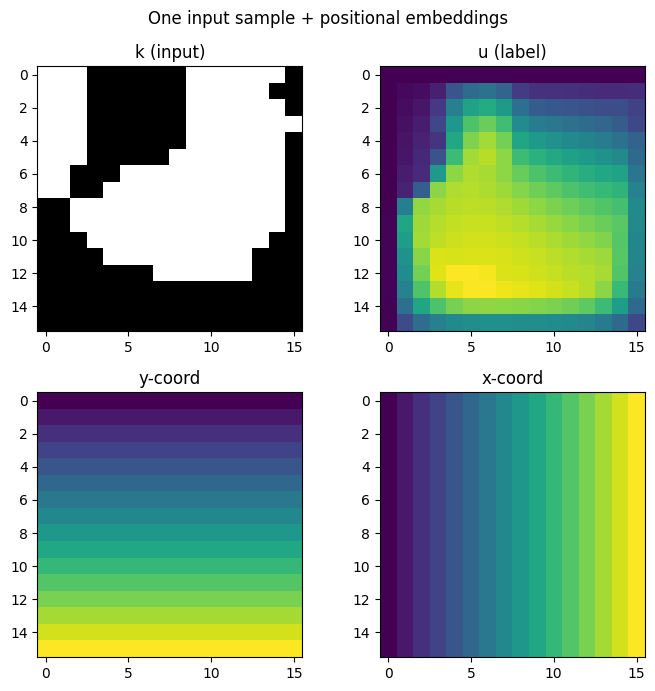

In [5]:
train_loader, test_loaders, data_processor = load_data()

visualize_single_sample(train_loader, data_processor)

### UNO training and visualisation

fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'

UNO has 2700097 parameters

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=1.62, avg_loss=0.6762, train_err=21.1309
Eval: 16_h1=0.3951, 16_l2=0.2513, 32_h1=0.8570, 32_l2=0.5732
[3] time=0.94, avg_loss=0.2348, train_err=7.3361
Eval: 16_h1=0.2498, 16_l2=0.1674, 32_h1=0.7876, 32_l2=0.5530
[6] time=0.93, avg_loss=0.2256, train_err=7.0495
Eval: 16_h1=0.3138, 16_l2=0.2119, 32_h1=0.7604, 32_l2=0.5215
[9] time=0.93, avg_loss=0.2184, train_err=6.8255
Eval: 16_h1=0.2482, 16_l2=0.1528, 32_h1=0.7682, 32_l2=0.4980
[12] time=0.93, avg_loss=0.2205, train_err=6.8910
Eval: 16_h1=0.2589, 16_l2=0.1590, 32_h1=0.7612, 32_l2=0.4684
[15] time=0.93, avg_loss=0.1597, train_err=4.9921
Eval: 16_h1=0.

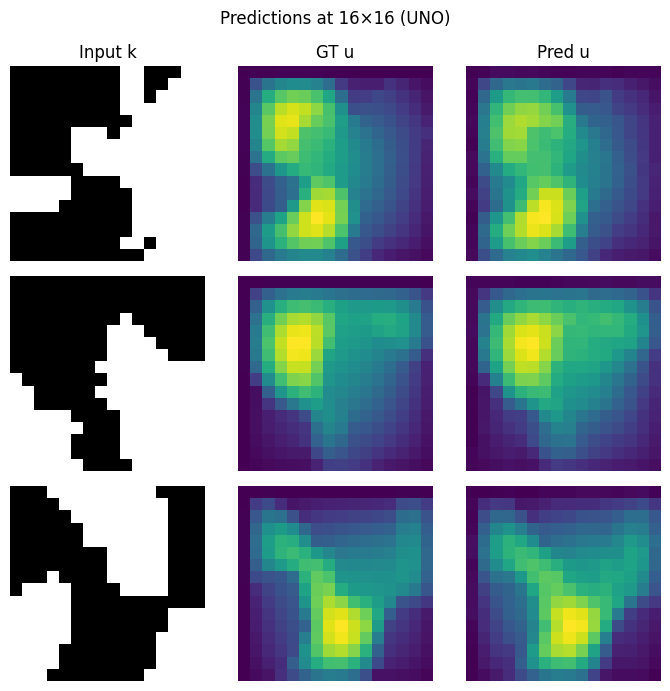

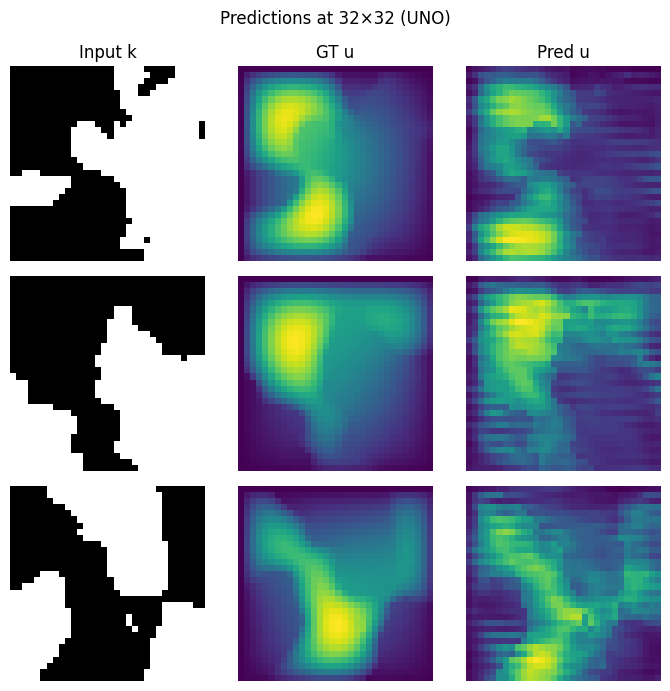

In [6]:
uno = UNO(
    in_channels=1,
    out_channels=1,
    hidden_channels=64,
    projection_channels=64,
    uno_out_channels=[32, 64, 64, 64, 32],
    uno_n_modes=[[16, 16], [8, 8], [8, 8], [8, 8], [16, 16]],
    uno_scalings=[[1.0, 1.0], [0.5, 0.5], [1, 1], [2, 2], [1, 1]],
    horizontal_skips_map=None,
    channel_mlp_skip="linear",
    n_layers=5,
    domain_padding=0.2,
)
uno = train_model(uno, train_loader, test_loaders, data_processor, name="UNO")

plot_prediction_grid(uno, data_processor, test_loaders[16], "16×16 (UNO)")
plot_prediction_grid(uno, data_processor, test_loaders[32], "32×32 (UNO)")

### FNO training and visualisation


FNO has 1192801 parameters

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=0.38, avg_loss=0.6052, train_err=18.9133
Eval: 16_h1=0.3849, 16_l2=0.2696, 32_h1=0.5917, 32_l2=0.2975
[3] time=0.34, avg_loss=0.2085, train_err=6.5165
Eval: 16_h1=0.2027, 16_l2=0.1362, 32_h1=0.4897, 32_l2=0.1801
[6] time=0.34, avg_loss=0.1771, train_err=5.5348
Eval: 16_h1=0.2040, 16_l2=0.1280, 32_h1=0.5128, 32_l2=0.1723
[9] time=0.34, avg_loss=0.1349, train_err=4.2160
Eval: 16_h1=0.2050, 16_l2=0.1404, 32_h1=0.4921, 32_l2=0.1627
[12] time=0.34, avg_loss=0.1450, train_err=4.5306
Eval: 16_h1=0.2274, 16_l2=0.1323, 32_h1=0.5738, 32_l2=0.1890
[15] time=0.33, avg_loss=0.1279, train_err=3.9983
Eval: 16_h1=0.2064, 16_l2=0.1243, 32_h1=0.5039, 32_l2=0.1736
[18] time=0.34, avg_loss=0.1023, train_err=3.1968
Eval: 16_h1=0.1910, 16_l2=0.1118, 32_h1=0.5343, 32_l2=0.1654


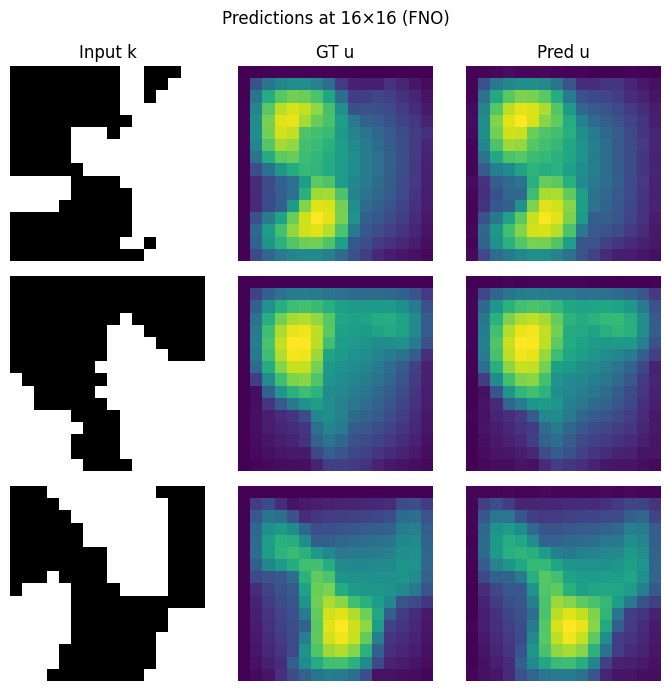

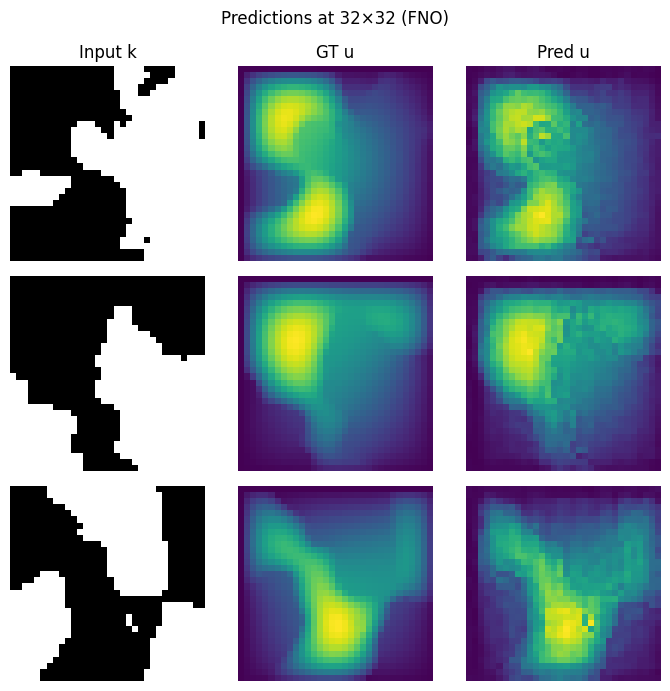

In [7]:
fno = FNO(
    n_modes=(16, 16),
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    projection_channel_ratio=2,
)
fno = train_model(fno, train_loader, test_loaders, data_processor, name="FNO")

plot_prediction_grid(fno, data_processor, test_loaders[16], "16×16 (FNO)")
plot_prediction_grid(fno, data_processor, test_loaders[32], "32×32 (FNO)")